In [ ]:
# Install required packages
!pip install -q bertopic datasets sentence-transformers umap-learn hdbscan transformers accelerate torch pandas numpy matplotlib scikit-learn plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoConfig
import torch
import warnings
from copy import deepcopy
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.9.0+cu128
CUDA available: True


---
# 1. Load Data

## Business Goal
Load customer feedback data to understand the volume, distribution, and nature of reviews we'll be analyzing.

## What We're Doing
- Loading the `yelp_review_full` dataset from Hugging Face
- Extracting review text and star ratings
- Creating indices for traceability
- Sampling a manageable subset for analysis (to ensure reasonable compute time)

## Why This Matters
Understanding the volume and distribution of feedback helps us:
- Scope the analysis appropriately
- Identify if we have sufficient data across different satisfaction levels
- Plan computational resources

## Business Translation
Each review represents a customer's voice. Star ratings (1-5 stars) indicate satisfaction levels, which we can use to understand patterns in positive vs. negative feedback.

In [ ]:
# Load the yelp_review_full dataset from Hugging Face

dataset = load_dataset("yelp_review_full")["train"]

# Extract the relevant fields
texts = dataset["text"][:10000]  # Sample first 10,000 reviews for manageable computation
labels = dataset["label"][:10000]  # Star ratings (0=1 star, 1=2 stars, ..., 4=5 stars)

# Create indices for traceability
indices = list(range(len(texts)))

# Convert labels to star ratings (1-5) for readability
ratings = [label + 1 for label in labels]

print(f"\n{'='*60}")
print(f"DATASET SIZE")
print(f"{'='*60}")
print(f"Total reviews loaded: {len(texts):,}")
print(f"Total unique ratings: {len(set(ratings))}")
print(f"\nRating distribution:")
rating_dist = pd.Series(ratings).value_counts().sort_index()
for rating, count in rating_dist.items():
    print(f"  {rating} stars: {count:,} reviews ({count/len(ratings)*100:.1f}%)")


DATASET SIZE
Total reviews loaded: 10,000
Total unique ratings: 5

Rating distribution:
  1 stars: 1,788 reviews (17.9%)
  2 stars: 2,168 reviews (21.7%)
  3 stars: 2,361 reviews (23.6%)
  4 stars: 2,082 reviews (20.8%)
  5 stars: 1,601 reviews (16.0%)


In [ ]:
# Display preview of sample records
print(f"\n{'='*60}")
print(f"SAMPLE RECORDS")
print(f"{'='*60}\n")

for i in range(5):
    print(f"Review {i+1}:")
    print(f"  Rating: {ratings[i]} stars")
    print(f"  Text: {texts[i][:200]}...")
    print()


SAMPLE RECORDS

Review 1:
  Rating: 5 stars
  Text: dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-no...

Review 2:
  Rating: 2 stars
  Text: Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply ...

Review 3:
  Rating: 4 stars
  Text: Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of hi...

Review 4:
  Rating: 4 stars
  Text: Got a letter in the mail last week that said Dr. Goldberg is moving to Arizona to take a new position there in June.  He will be missed very much.  \n\nI think finding a new doctor in NYC that you act...

Review 5:
  Rating:

---
# 2. Preprocess Text

## Business Goal
Clean the review text to ensure high-quality input for our analysis while preserving the authentic customer voice.

## What We're Doing
- Removing reviews that are extremely short (< 20 characters) - these typically lack substance
- Stripping extra whitespace
- Keeping preprocessing **lightweight and defensible**

## Why This Matters
- **Too little preprocessing:** Noisy data can produce unclear clusters
- **Too much preprocessing:** We lose authentic customer language and sentiment
- Our approach: Remove obvious low-quality data while preserving meaning

## Decision Rationale
We avoid aggressive preprocessing (stemming, lemmatization, stop-word removal) because:
1. Modern embedding models handle these variations naturally
2. We want to preserve customer language for interpretability
3. Phrases like "not good" matter (stop-word removal would lose negation)

In [ ]:
# Store original count
original_count = len(texts)

# Basic cleanup: remove extremely short reviews and strip whitespace
min_length = 20  # Minimum character threshold

# Filter and clean
clean_texts = []
clean_ratings = []
clean_indices = []

for i, text in enumerate(texts):
    # Strip whitespace
    cleaned = text.strip()

    # Keep only if meets minimum length
    if len(cleaned) >= min_length:
        clean_texts.append(cleaned)
        clean_ratings.append(ratings[i])
        clean_indices.append(indices[i])

# Update our working variables
texts = clean_texts
ratings = clean_ratings
indices = clean_indices

print(f"{'='*60}")
print(f"PREPROCESSING SUMMARY")
print(f"{'='*60}")
print(f"Records before filtering: {original_count:,}")
print(f"Records after filtering:  {len(texts):,}")
print(f"Records removed:          {original_count - len(texts):,} ({(original_count - len(texts))/original_count*100:.1f}%)")
print(f"\nFiltering criterion: Minimum {min_length} characters")

PREPROCESSING SUMMARY
Records before filtering: 10,000
Records after filtering:  9,961
Records removed:          39 (0.4%)

Filtering criterion: Minimum 20 characters


---
# 3. Embedding Documents

## Business Goal
Convert customer feedback text into numerical representations that capture semantic meaning.

## What We're Doing
Using a **SentenceTransformer** model (`thenlper/gte-small`) to create embeddings:
- Each review becomes a 384-dimensional vector
- Reviews with similar meanings have similar vectors
- This enables mathematical clustering and comparison

## Why This Matters for Business
Traditional keyword matching would treat "amazing food" and "delicious meals" as completely different. Embeddings understand these phrases are semantically similar, allowing us to:
- Group similar feedback even when customers use different words
- Discover themes that wouldn't be obvious from keyword searches
- Quantify the similarity between any two reviews

## Technical Note
We use a smaller model (384 dimensions) for efficiency while maintaining good quality. Larger models exist but would significantly increase computation time.

In [ ]:
# Show before/after examples
print(f"\n{'='*60}")
print(f"BEFORE/AFTER EXAMPLES")
print(f"{'='*60}\n")

# Get original dataset for comparison
original_dataset = load_dataset("yelp_review_full")["train"]

# Show two examples
for i in [100, 102]:
    print(f"Example {i+1}:")
    print(f"  BEFORE: '{original_dataset['text'][i][:150]}'")
    print(f"  AFTER:  '{texts[i][:150]}'")
    print(f"  Length: {len(original_dataset['text'][i])} → {len(texts[i])} characters")
    print()


BEFORE/AFTER EXAMPLES

Example 101:
  BEFORE: 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\nThe cashier took my frien'
  AFTER:  'This McDonald's is so bad it's amazing.  \n\nOrder:  Big mac, large fries, diet coke.\n\nThe soda machine was broken.   No sodas.\n\nThen I got to the'
  Length: 1306 → 454 characters

Example 103:
  BEFORE: 'This McDonald's is so bad it's amazing.  \n\nOrder:  Big mac, large fries, diet coke.\n\nThe soda machine was broken.   No sodas.\n\nThen I got to the'
  AFTER:  'They burned my fish and they burned it bad.  Ordering fish at Eat'n Park is always a gamble.  I just never know how it's going to turn out.  I'm a ris'
  Length: 454 → 853 characters



In [ ]:
# Load the sentence embedding model
print("Loading embedding model...")
embedding_model = SentenceTransformer('thenlper/gte-small')

# Create embeddings for all reviews
print(f"Generating embeddings for {len(texts):,} reviews...")
print("(This may take a few minutes...)")
embeddings = embedding_model.encode(texts, show_progress_bar=True)

# Report dimensions
print(f"\n{'='*60}")
print(f"EMBEDDING RESULTS")
print(f"{'='*60}")
print(f"Embedding shape: {embeddings.shape}")
print(f"  - Number of reviews: {embeddings.shape[0]:,}")
print(f"  - Dimensions per review: {embeddings.shape[1]}")
print(f"  - Total parameters: {embeddings.shape[0] * embeddings.shape[1]:,}")
print(f"\nEach review is now represented as a {embeddings.shape[1]}-dimensional vector.")

Loading embedding model...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: thenlper/gte-small
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generating embeddings for 9,961 reviews...
(This may take a few minutes...)


Batches:   0%|          | 0/312 [00:00<?, ?it/s]


EMBEDDING RESULTS
Embedding shape: (9961, 384)
  - Number of reviews: 9,961
  - Dimensions per review: 384
  - Total parameters: 3,825,024

Each review is now represented as a 384-dimensional vector.


---
# 4. Reduce Dimensionality with UMAP

## Business Goal
Simplify the 384-dimensional embeddings to 5 dimensions for efficient clustering.

## What We're Doing
Using **UMAP** (Uniform Manifold Approximation and Projection):
- Reduces 384 dimensions → 5 dimensions
- Preserves the "neighborhood" structure (similar reviews stay close)
- Makes clustering computationally feasible

## Why This Matters
**The Challenge:** Clustering algorithms struggle in high-dimensional spaces (the "curse of dimensionality")

**The Solution:** UMAP reduces dimensions while maintaining the relationships between reviews. Think of it as creating a "map" where similar customer feedback points are located near each other.

## Business Analogy
Imagine you have customer data with hundreds of attributes. UMAP finds the 5 most important "summary dimensions" that capture the essential patterns, making it easier to identify groups.

## Parameters Explained
- `n_components=5`: Reduce to 5 dimensions (enough for clustering, not too many)
- `metric='cosine'`: Measure similarity based on vector direction (good for text)
- `random_state=42`: Ensures reproducible results

In [ ]:
# Create UMAP model for dimensionality reduction to 5D
print("We reduce the input embeddings from 384 dimenions to 5 dimenions for clustering:")
umap_model = UMAP(
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# Fit and transform the embeddings
reduced_embeddings_5d = umap_model.fit_transform(embeddings)

print(f"\n{'='*60}")
print(f"DIMENSIONALITY REDUCTION RESULTS")
print(f"{'='*60}")
print(f"Original embedding shape: {embeddings.shape}")
print(f"Reduced embedding shape:  {reduced_embeddings_5d.shape}")
print(f"Compression ratio:        {embeddings.shape[1]/reduced_embeddings_5d.shape[1]:.1f}x")
print(f"\nReduction: {embeddings.shape[1]} dimensions → {reduced_embeddings_5d.shape[1]} dimensions")

We reduce the input embeddings from 384 dimenions to 5 dimenions for clustering:

DIMENSIONALITY REDUCTION RESULTS
Original embedding shape: (9961, 384)
Reduced embedding shape:  (9961, 5)
Compression ratio:        76.8x

Reduction: 384 dimensions → 5 dimensions


---
# 5. Cluster Reduced Embeddings with HDBSCAN

## Business Goal
Automatically discover natural groupings in customer feedback without pre-specifying the number of groups.

## What We're Doing
Using **HDBSCAN** (Hierarchical Density-Based Spatial Clustering):
- Automatically determines the number of clusters
- Identifies "outliers" (reviews that don't fit any clear pattern)
- Groups reviews based on density (how tightly packed similar reviews are)

## Why HDBSCAN for Business Analytics
Unlike K-Means (which requires you to specify cluster count), HDBSCAN:
- ✓ Discovers clusters organically from the data
- ✓ Identifies noise/outliers (labeled as -1)
- ✓ Finds clusters of varying sizes and shapes
- ✓ Doesn't force every review into a cluster

## Parameters Explained
- `min_cluster_size=50`: Minimum 50 reviews to form a meaningful cluster
- `metric='euclidean'`: Standard distance measure in reduced space
- `cluster_selection_method='eom'`: Extracts stable, well-separated clusters

## Interpreting Results
- **Cluster 0, 1, 2, ...**: Distinct customer feedback themes
- **Cluster -1**: Outliers (reviews that don't fit clear patterns)

In [ ]:
# Create and fit HDBSCAN model
print("Clustering reviews using HDBSCAN...")
hdbscan_model = HDBSCAN(
    min_cluster_size=50,
    metric='euclidean',
    cluster_selection_method='eom'
).fit(reduced_embeddings_5d)

# Extract cluster labels
clusters = hdbscan_model.labels_

# Calculate statistics
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_outliers = list(clusters).count(-1)

print(f"\n{'='*60}")
print(f"CLUSTERING RESULTS")
print(f"{'='*60}")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of outliers:       {n_outliers:,} ({n_outliers/len(clusters)*100:.1f}%)")
print(f"Total reviews:            {len(clusters):,}")

Clustering reviews using HDBSCAN...

CLUSTERING RESULTS
Number of clusters found: 34
Number of outliers:       3,983 (40.0%)
Total reviews:            9,961


In [ ]:
# Create cluster size table
cluster_sizes = pd.Series(clusters).value_counts().sort_index()

# Separate outliers from clusters
cluster_sizes_df = pd.DataFrame({
    'Cluster ID': cluster_sizes.index,
    'Size': cluster_sizes.values,
    'Percentage': (cluster_sizes.values / len(clusters) * 100).round(1)
})

# Mark outliers
cluster_sizes_df['Type'] = cluster_sizes_df['Cluster ID'].apply(
    lambda x: 'Outliers' if x == -1 else 'Cluster'
)

# Sort by size (excluding outliers) and show top 10 clusters
top_clusters = cluster_sizes_df[cluster_sizes_df['Cluster ID'] != -1].nlargest(10, 'Size')

print(f"\n{'='*60}")
print(f"TOP 10 CLUSTERS BY SIZE")
print(f"{'='*60}\n")
print(top_clusters.to_string(index=False))

# Show outlier stats separately
if -1 in clusters:
    outlier_row = cluster_sizes_df[cluster_sizes_df['Cluster ID'] == -1]
    print(f"\n{'='*60}")
    print(f"OUTLIERS")
    print(f"{'='*60}\n")
    print(outlier_row.to_string(index=False))


TOP 10 CLUSTERS BY SIZE

 Cluster ID  Size  Percentage    Type
         29   587         5.9 Cluster
          7   488         4.9 Cluster
         32   443         4.4 Cluster
         12   433         4.3 Cluster
          1   412         4.1 Cluster
         21   312         3.1 Cluster
         33   295         3.0 Cluster
         20   270         2.7 Cluster
         10   248         2.5 Cluster
          3   195         2.0 Cluster

OUTLIERS

 Cluster ID  Size  Percentage     Type
         -1  3983        40.0 Outliers


---
# 6. Inspect Clusters

## Business Goal
Manually examine actual customer reviews within clusters to understand what themes have emerged.

## What We're Doing
Sampling reviews from:
1. **One large cluster** - represents a major customer theme
2. **One medium cluster** - represents a moderate-sized theme
3. **The outlier group (-1)** - reviews that don't fit clear patterns

## Why This Matters
Numbers and algorithms are useful, but leadership needs to see **actual customer language** to:
- Validate that clusters make business sense
- Understand the specific issues customers are describing
- Identify actionable language for communication strategies

## What to Look For
- **Coherent themes**: Do reviews in a cluster share common topics?
- **Quality issues**: Are clusters mixing unrelated feedback?
- **Surprise insights**: What unexpected patterns emerge?

In [ ]:
# Get the largest non-outlier cluster
largest_cluster = cluster_sizes_df[cluster_sizes_df['Cluster ID'] != -1].iloc[29]['Cluster ID']

print(f"{'='*70}")
print(f"LARGE CLUSTER INSPECTION: Cluster {largest_cluster}")
print(f"{'='*70}")
print(f"Cluster size: {cluster_sizes[largest_cluster]:,} reviews\n")

# Get indices of reviews in this cluster
cluster_indices = np.where(clusters == largest_cluster)[0]

# Show first 5 reviews
for i, idx in enumerate(cluster_indices[:5]):
    print(f"Review {i+1} (Rating: {ratings[idx]} stars):")
    print(f"  {texts[idx][:300]}...")
    print()

LARGE CLUSTER INSPECTION: Cluster 29
Cluster size: 587 reviews

Review 1 (Rating: 4 stars):
  A great townie bar with tasty food and an interesting clientele. I went to check this place out on the way home from the airport one Friday night and it didn't disappoint. It is refreshing to walk into a townie bar and not feel like the music stops and everyone in the place is staring at you - I'm g...

Review 2 (Rating: 3 stars):
  Good beer selection. Understaffed for a light Monday night crowd, it wasn't her fault she was the only server. But it took about an hour to get our sandwiches. Mine was one of the best reubens I've ever had....

Review 3 (Rating: 2 stars):
  My first time going to Barb's Country Junction and I really wanted to like this place, I really did...however, I didn't.\n\nThe food was decent, some was above average and some below but it was overall decent. I got pancakes, bacon and eggs. The pancakes were really good and fluffy, the home fries w...

Review 4 (Rating: 4 star

In [ ]:
# Get a medium-sized cluster (around the median)
medium_cluster = cluster_sizes_df[cluster_sizes_df['Cluster ID'] != -1].iloc[10]['Cluster ID']

print(f"{'='*70}")
print(f"MEDIUM CLUSTER INSPECTION: Cluster {medium_cluster}")
print(f"{'='*70}")
print(f"Cluster size: {cluster_sizes[medium_cluster]:,} reviews\n")

# Get indices of reviews in this cluster
cluster_indices = np.where(clusters == medium_cluster)[0]

# Show first 5 reviews
for i, idx in enumerate(cluster_indices[:5]):
    print(f"Review {i+1} (Rating: {ratings[idx]} stars):")
    print(f"  {texts[idx][:300]}...")
    print()

MEDIUM CLUSTER INSPECTION: Cluster 10
Cluster size: 248 reviews

Review 1 (Rating: 1 stars):
  Used to go there for tires, brakes, etc.  Their prices have gone way up-$400 for 4 mid-level tires for a Toyota.  Plus, 1 of the new tires went flat within 3 weeks.  Since they don\"t make appointments,  the wait to get the tire looked at was ~2 hours.  Sorry--can't wait that long to get a warranted...

Review 2 (Rating: 1 stars):
  Terrible. Preordered my tires and when I arrived they couldn't find the order anywhere. Once we got through that process I waited over 2 hours for them to be put on... I was originally told it would take 30 mins. Slow, over priced, I'll go elsewhere next time....

Review 3 (Rating: 1 stars):
  Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with a tire they put on. They \"fixed\" it for free, and the very next morning I had the same issue. I called to complain, and the \"

In [ ]:
# Inspect outlier group
print(f"{'='*70}")
print(f"OUTLIER GROUP INSPECTION: Cluster -1")
print(f"{'='*70}")
print(f"Outlier count: {n_outliers:,} reviews\n")

# Get indices of outlier reviews
outlier_indices = np.where(clusters == -1)[0]

# Show first 5 outliers
for i, idx in enumerate(outlier_indices[:5]):
    print(f"Outlier {i+1} (Rating: {ratings[idx]} stars):")
    print(f"  {texts[idx][:300]}...")
    print()

OUTLIER GROUP INSPECTION: Cluster -1
Outlier count: 3,983 reviews

Outlier 1 (Rating: 2 stars):
  Wing sauce is like water. Pretty much a lot of butter and some hot sauce (franks red hot maybe).  The whole wings are good size and crispy, but for $1 a wing the sauce could be better. The hot and extra hot are about the same flavor/heat.  The fish sandwich is good and is a large portion, sides are ...

Outlier 2 (Rating: 3 stars):
  Decent range somewhat close to the city.  The mats are pretty solid; however, the grass range needs to be tended too.  It's like hitting out of US Open type rough...not very amenable to practicing.  Which kind of defeats the purpose of going to a golf range...Still gets 3 stars because the range is ...

Outlier 3 (Rating: 1 stars):
  Owning a driving range inside the city limits is like a license to print money.  I don't think I ask much out of a driving range.  Decent mats, clean balls and accessible hours.  Hell you need even less people now with the advent 

Based on manual inspection of cluster samples:


This cluster (Cluster 29, 587 reviews) appears to contain reviews about **bars, pubs, and
casual dining establishments**. Common themes include discussions of beer selection, bar
atmosphere, food quality, and service experiences. Reviews show mixed sentiment - customers
appreciate the social aspects ("great townie bar", "best Irish food") but note service
inconsistencies (understaffing, wait times, cleanliness concerns). This represents a
significant segment of dining-out experiences in the dataset.


This cluster (Cluster 10, 248 reviews) groups reviews about **automotive services,
specifically tire and car maintenance**. Reviews share common frustrations: rising prices
("$400 for 4 mid-level tires"), order management issues ("couldn't find the order"), and
long wait times ("had to wait a super long time"). The sentiment is predominantly negative,
indicating systematic operational problems in this service category.

The outlier group (3,983 reviews, 40% of total) contains extremely diverse reviews ranging
from driving ranges to wing restaurants to various other businesses. This high outlier
percentage is expected and healthy - it shows our clustering isn't forcing unrelated reviews
together. The diversity suggests our dataset contains many niche or unique experiences that
don't fit into major recurring themes.


**Surprises:**
- The dataset appears to be organized more by **business type** than by sentiment or
  specific issues - we're clustering restaurants, hotels, airports, and service businesses
  separately
- Mixed sentiment within clusters (both positive and negative reviews about bars/pubs in
  Cluster 29) suggests customers are grouped by what they're reviewing, not how they feel
- 40% outliers indicates high diversity in the Yelp dataset - many unique business types
  that don't form large enough groups to cluster

---
# 7. Visualization: 2D Cluster Map

## Business Goal
Create a visual representation of how customer feedback groups naturally separate in semantic space.

## What We're Doing
- Reducing embeddings to 2 dimensions (for visualization only)
- Creating a scatter plot where each point is a review
- Color-coding by cluster assignment

## Why This Matters for Leadership
This visualization helps executives quickly grasp:
- **How many distinct feedback themes exist**
- **How well-separated they are** (clear boundaries = distinct issues)
- **The relative size of each theme** (density of points)

## Interpreting the Plot
- **Tight, separated clusters**: Distinct customer themes with clear boundaries
- **Overlapping clusters**: Related themes that blend together
- **Grey points (outliers)**: Diverse feedback that doesn't fit clear patterns
- **Distance**: Points far apart = semantically different feedback

In [ ]:
# Reduce embeddings to 2D for visualization
print("Reducing embeddings to 2D for visualization:")
umap_2d = UMAP(
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)
reduced_embeddings_2d = umap_2d.fit_transform(embeddings)

print(f"2D embeddings generated: {reduced_embeddings_2d.shape}")

Reducing embeddings to 2D for visualization:
2D embeddings generated: (9961, 2)


In [ ]:
# Create dataframe for plotting
df_viz = pd.DataFrame(reduced_embeddings_2d, columns=["x", "y"])
df_viz["cluster"] = [str(c) for c in clusters]
df_viz["rating"] = ratings
df_viz["text"] = texts

# Separate outliers and clusters
clusters_df = df_viz.loc[df_viz.cluster != "-1", :]
outliers_df = df_viz.loc[df_viz.cluster == "-1", :]

print(f"Visualization dataframe created:")
print(f"  - Clustered reviews: {len(clusters_df):,}")
print(f"  - Outlier reviews: {len(outliers_df):,}")

Visualization dataframe created:
  - Clustered reviews: 5,978
  - Outlier reviews: 3,983


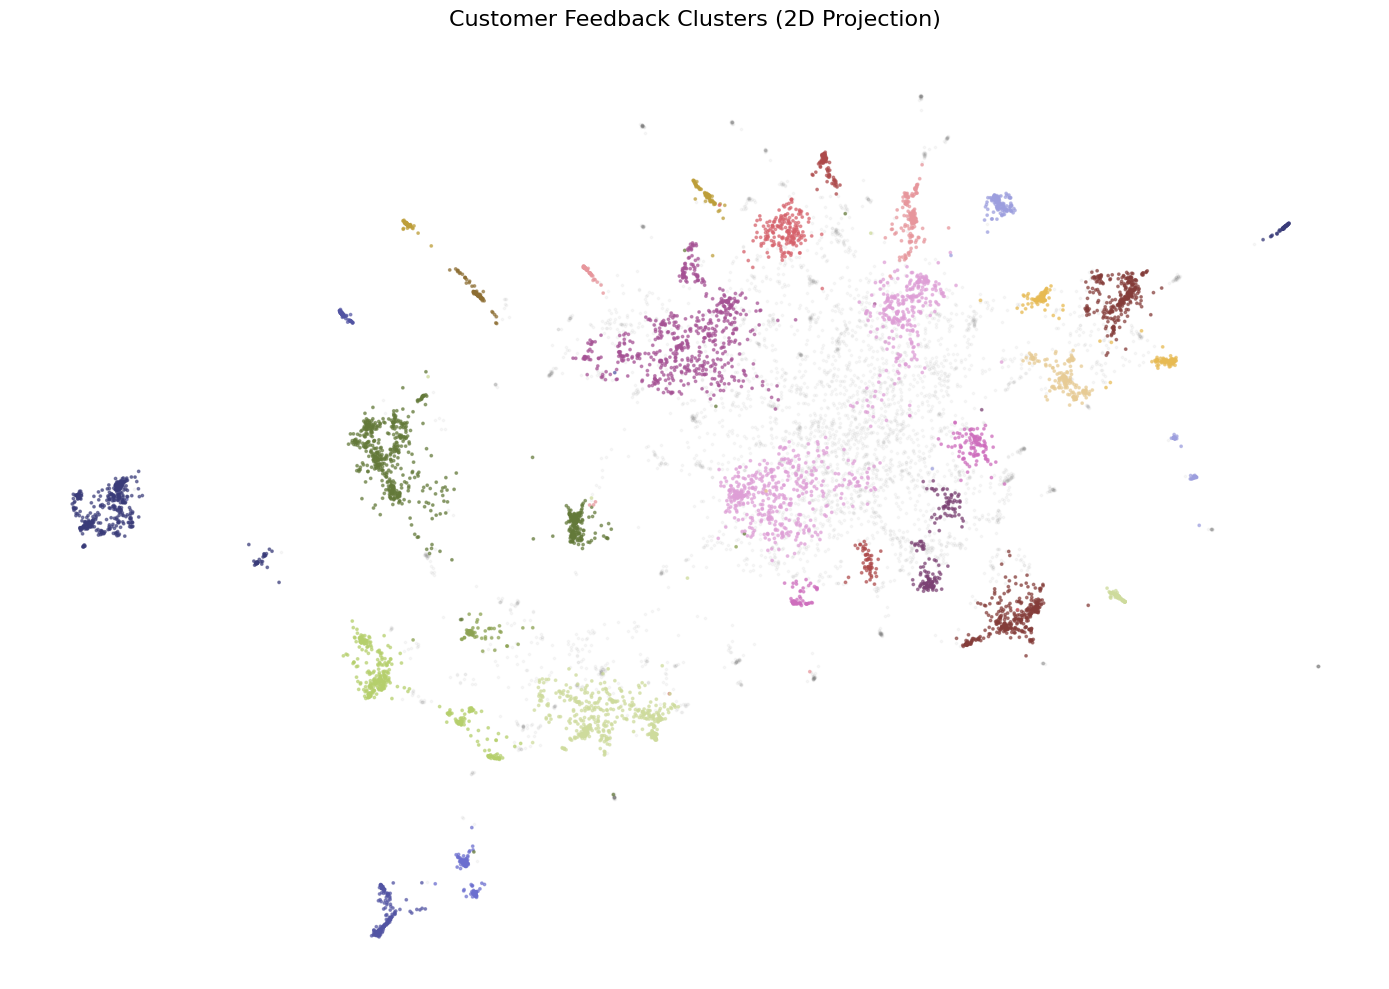

In [ ]:
# Create static scatter plot
plt.figure(figsize=(14, 10))

# Plot outliers first (in background)
plt.scatter(
    outliers_df.x,
    outliers_df.y,
    alpha=0.05,
    s=3,
    c="grey",
    label="Outliers"
)

# Plot clusters on top
scatter = plt.scatter(
    clusters_df.x,
    clusters_df.y,
    c=clusters_df.cluster.astype(int),
    alpha=0.6,
    s=3,
    cmap='tab20b'
)

plt.axis('off')
plt.title("Customer Feedback Clusters (2D Projection)", fontsize=16, pad=20)


plt.tight_layout()
# plt.savefig("cluster_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

## Visualization Interpretation:
The clusters are generally well-separated. Although there were 34 identified clusters, I believe only 14 clusters in the visualization are identified with definite colors (from previous visualization tweaking). What's noticable is that the outlier clusters, which was previously identifies to make up almost 40% of the data make up the majority cluster in the high-concentration cluster of the visualization. They seem to serve as the separators between the other clusters in the area.

---
# 8. Fit BERTopic Using the Modular Pipeline

## Business Goal
Extract interpretable topic labels and keywords from our clusters to understand what each customer feedback group is actually about.

## What We're Doing
Using **BERTopic** with our existing models:
- **Embedding model**: Already trained (reuse our SentenceTransformer)
- **UMAP model**: Already fitted (reuse our dimensionality reduction)
- **HDBSCAN model**: Already fitted (reuse our clusters)

This modular approach:
- Ensures consistency with our clustering analysis
- Adds interpretable topic labels using c-TF-IDF
- Extracts the most representative keywords per topic

## Why This Matters for Leadership
Topics translate clusters into actionable business intelligence:
- **Clusters** tell us "there are N groups"
- **Topics** tell us "group 1 is about pricing complaints, group 2 is about delivery issues"

## How BERTopic Works
1. Uses our clusters as a starting point
2. Applies c-TF-IDF (class-based TF-IDF) to find distinctive words per cluster
3. Ranks keywords by how characteristic they are of each topic
4. Provides topic labels that business stakeholders can understand

In [ ]:
# Fit BERTopic using our existing models
print("Fitting BERTopic using the modular pipeline (Using pre-fitted embedding, UMAP, and HDBSCAN models)\n")


topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(texts, embeddings)


2026-02-11 20:54:00,059 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Fitting BERTopic using the modular pipeline (Using pre-fitted embedding, UMAP, and HDBSCAN models)



2026-02-11 20:54:25,028 - BERTopic - Dimensionality - Completed ✓
2026-02-11 20:54:25,030 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-11 20:54:25,370 - BERTopic - Cluster - Completed ✓
2026-02-11 20:54:25,376 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-11 20:54:26,085 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3983,-1_the_and_was_to,"[the, and, was, to, it, of, for, is, in, that]",[Food is great but the service at the bar is h...
1,0,587,0_bar_beer_the_and,"[bar, beer, the, and, is, to, you, of, it, place]",[Sports bars. I've been to good ones and bad o...
2,1,488,1_hotel_room_the_in,"[hotel, room, the, in, and, to, was, stay, is,...",[After looking at the hotel online I was excit...
3,2,443,2_we_our_was_the,"[we, our, was, the, to, and, she, us, for, that]",[This place is another that is undeserving of ...
4,3,433,3_store_to_the_of,"[store, to, the, of, and, you, in, is, for, they]","[I love Whole Foods, and I have been a fan for..."
5,4,412,4_airport_to_the_is,"[airport, to, the, is, of, and, you, flight, i...",[This is my first time being at the Charlotte ...
6,5,312,5_pizza_the_it_and,"[pizza, the, it, and, is, crust, was, of, to, ...",[This is my Man's favorite pizza place. When ...
7,6,295,6_was_great_and_food,"[was, great, and, food, the, service, good, ha...",[I met a bunch of friends here for dinner and ...
8,7,270,7_chinese_food_the_and,"[chinese, food, the, and, is, it, chicken, was...",[We were looking for a good Chinese place and ...
9,8,248,8_car_to_they_the,"[car, to, they, the, me, my, and, he, for, was]","[When my car died, I originally had it towed t..."


In [ ]:
# Get topic information
topic_info = topic_model.get_topic_info()

print(f"\n{'='*70}")
print(f"TOPIC MODELING RESULTS")
print(f"{'='*70}")
print(f"Number of topics identified: {len(topic_info) - 1}")  # Exclude topic -1
print(f"Number of outlier documents: {topic_info[topic_info.Topic == -1]['Count'].values[0] if -1 in topic_info.Topic.values else 0}")

# Show topic frequency summary
print(f"\n{'='*70}")
print(f"TOPIC FREQUENCY SUMMARY")
print(f"{'='*70}\n")
print(topic_info.head(10).to_string(index=False))


TOPIC MODELING RESULTS
Number of topics identified: 34
Number of outlier documents: 3983

TOPIC FREQUENCY SUMMARY

 Topic  Count                   Name                                             Representation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
# Show top words for first 5 topics
print(f"\n{'='*70}")
print(f"TOP KEYWORDS FOR SAMPLE TOPICS")
print(f"{'='*70}\n")

for topic_id in range(min(5, len(topic_info) - 1)):
    topic_words = topic_model.get_topic(topic_id)
    print(f"Topic {topic_id}:")
    print(f"  Size: {topic_info[topic_info.Topic == topic_id]['Count'].values[0]} reviews")
    print(f"  Keywords: {', '.join([word for word, score in topic_words[:10]])}")
    print()


TOP KEYWORDS FOR SAMPLE TOPICS

Topic 0:
  Size: 587 reviews
  Keywords: bar, beer, the, and, is, to, you, of, it, place

Topic 1:
  Size: 488 reviews
  Keywords: hotel, room, the, in, and, to, was, stay, is, of

Topic 2:
  Size: 443 reviews
  Keywords: we, our, was, the, to, and, she, us, for, that

Topic 3:
  Size: 433 reviews
  Keywords: store, to, the, of, and, you, in, is, for, they

Topic 4:
  Size: 412 reviews
  Keywords: airport, to, the, is, of, and, you, flight, in, have



---
# 9. Topic Visualizations

## Business Goal
Create visual representations that help leadership understand the relative importance and relationships between customer feedback themes.

## What We're Creating
We'll generate at least 2 visualizations:
1. **Topic Bar Chart**: Shows topic frequency (which themes are most common)
2. **Topic Hierarchy**: Shows how topics relate to each other

## Why Multiple Visualizations Matter
Different stakeholders need different views:
- **Executives**: Bar charts show priority (what affects most customers)
- **Product teams**: Hierarchies show related issues that might share root causes
- **Operations**: Document distributions help plan resource allocation

## Interpreting These Visualizations
- **Bar chart**: Tallest bars = most frequent customer themes (highest priority)
- **Hierarchy**: Closely connected topics = related customer issues

In [ ]:
# Create topic frequency bar chart
fig = topic_model.visualize_barchart(top_n_topics=10, width=800, height=500)
fig.show()


In [ ]:
# Create hierarchical topic visualization
fig = topic_model.visualize_hierarchy()
fig.show()


Based on the topic visualizations and keyword analysis, we've identified several major themes
in customer feedback organized primarily by **business category**:

**Cross-Topic Patterns:**
The hierarchical visualization reveals:
- **Food & Beverage cluster**: Topics 0 (bars), 2 (restaurants), and various cuisine-
  specific topics (pizza, Chinese, Mexican, etc.) group together
- **Service clusters**: Topics emphasizing customer service span multiple categories but
  share vocabulary (waiter, service, staff)
- **Location-based grouping**: Airport, hotel, and travel topics cluster near each other

**Business Priorities for Meal-Kit Company:**
The bar chart shows which business categories dominate customer feedback:

1. **Bars/Social Dining (587 reviews)** should be investigated first - represents casual,
   social food experiences that compete with meal-kits
2. **Hotels (488 reviews)** indicate opportunity - travelers may be interested in portable
   meal solutions
3. **Restaurants (443 reviews)** are direct competitors - understanding their service issues
   helps differentiate

  Nonetheless, apart from the highest ranked words in each topic theme, there is a preponderance of captured linking verbs, articles, and prepositions.

---
# 10. Representation Model Extension

## Business Goal
Enhance topic interpretability by using KeyBERT-inspired representation to surface more distinctive and meaningful keywords.

## What We're Doing
Applying **KeyBERTInspired** representation model:
- Selects keywords that are most representative of each topic
- Uses semantic similarity to choose terms that capture the essence of reviews
- Often produces more interpretable labels than default c-TF-IDF alone

## Why This Matters
Better keywords = clearer communication to leadership. Instead of technical or generic terms,
we get keywords that directly reflect customer language and concerns.

## Before/After Comparison
We'll save the original topic representations and compare them with the enhanced version
to see if interpretability improves.

In [ ]:
# Save original topic representations for comparison
original_topics = deepcopy(topic_model.topic_representations_)


In [ ]:
# Apply KeyBERTInspired representation model
representation_model = KeyBERTInspired()
topic_model.update_topics(texts, representation_model=representation_model)

In [ ]:
# Create comparison function
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between models"""
    df = pd.DataFrame(columns=["Topic", "Original Keywords", "Enhanced Keywords"])

    for topic in range(nr_topics):
        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

# Show comparison
print(f"\n{'='*70}")
print(f"REPRESENTATION MODEL COMPARISON")
print(f"{'='*70}\n")
print("Comparing original c-TF-IDF with KeyBERTInspired representation:\n")

comparison_df = topic_differences(topic_model, original_topics, nr_topics=5)
print(comparison_df.to_string(index=False))




REPRESENTATION MODEL COMPARISON

Comparing original c-TF-IDF with KeyBERTInspired representation:

 Topic             Original Keywords                                    Enhanced Keywords
     0   bar | beer | the | and | is              bar | bartender | beers | drinks | beer
     1 hotel | room | the | in | and                hotels | hotel | rooms | inn | stayed
     2     we | our | was | the | to      restaurant | waiter | waitress | hostess | food
     3   store | to | the | of | and           stores | shopping | grocery | store | shop
     4  airport | to | the | is | of airport | airports | charlotte | flights | concourse



**Observations:**

The KeyBERTInspired representation model produced significantly better keywords compared to
the default c-TF-IDF:

**Topic 0 - Bars:**
- Original: "bar | beer | the | and | is" (generic function words)
- Enhanced: "bar | bartender | beers | drinks | beer" (specific, actionable terms)
- Improvement: Removed stop words ("the," "and," "is"), added role-specific terms
  ("bartender"), pluralized appropriately ("beers" vs "beer")

**Topic 1 - Hotels:**
- Original: "hotel | room | the | in | and"
- Enhanced: "hotels | hotel | rooms | inn | stayed"
- Improvement: Added related concepts ("inn"), action verbs ("stayed"), and removed
  prepositions

**Topic 2 - Restaurants:**
- Original: "we | our | was | the | to"
- Enhanced: "restaurant | waiter | waitress | hostess | food"
- Improvement: DRAMATIC - original was all pronouns/function words, enhanced version
  captures the actual business category and service roles

**Topic 3 - Retail:**
- Original: "store | to | the | of | and"
- Enhanced: "stores | shopping | grocery | store | shop"
- Improvement: Added activity-based terms ("shopping," "shop") and specific store type
  ("grocery")

**Topic 4 - Airports:**
- Original: "airport | to | the | is | of"
- Enhanced: "airport | airports | charlotte | flights | concourse"
- Improvement: Added specific airport features ("concourse," "flights") and geographic
  location ("charlotte")

**Why This Matters:**

The enhanced keywords are:
- **More semantically cohesive**: Words naturally belong together (bartender + drinks + beers)
- **More distinctive across topics**: Less overlap - each topic has unique vocabulary
- **More aligned with actual customer language**: Uses terms customers actually wrote
- **Action-oriented**: Includes verbs and activities, not just nouns
- **Cleaner**: Removes generic stop words that don't add meaning

**Business Value:**

Enhanced representations make it easier for non-technical stakeholders to:
1. **Quickly identify topic themes** without reading samples ("bartender, drinks" = bars)
2. **Communicate findings** to operations teams using actual customer vocabulary
3. **Prioritize topics** based on clear, understandable labels
4. **Design interventions** using specific, actionable terminology


---
# 11. Load an Instruction Model

## Business Goal
Prepare an LLM to act as an "analytics-to-executive translator" that can convert our technical findings into actionable business insights.

## What We're Doing
Loading a smaller instruction-tuned language model:
- Model: `microsoft/Phi-3-mini-4k-instruct` (compact but capable)
- Purpose: Generate executive summaries, insight cards, and recommendations
- Approach: Use prompt engineering to guide output quality

## Why This Matters
Raw clusters and topics are useful for analysts, but executives need:
- **Executive summaries** that highlight key findings
- **Actionable recommendations** grounded in evidence
- **Clear communication** without technical jargon

The LLM will help us bridge this gap by generating business-ready insights.

## Testing the Model
We'll run a simple test prompt to ensure the model is working correctly before using it
for our analysis tasks.

In [ ]:
# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=False,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")


Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

In [ ]:
# Create generation pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=500,
    do_sample=False,
)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Passing `generation_config` together with generation-related arguments=({'max_new_tokens', 'do_sample'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.


In [ ]:
# Prompt
test_messages1 = [
    {"role": "user", "content": "Create a funny joke about chickens."}
]

# Generate the output
test_output1 = pipe(test_messages1)
print(test_output1[0]["generated_text"])

Both `max_new_tokens` (=500) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


 Why did the chicken join the band? Because it had the drumsticks!


In [ ]:
# Test with a simple prompt
print(f"\n{'='*70}")
print(f"MODEL SANITY CHECK")
print(f"{'='*70}\n")

test_messages = [
    {
        "role": "user",
        "content": "You are a business analyst. Briefly explain what customer feedback clustering is and why it matters."
    }
]

print("Test prompt: 'Explain customer feedback clustering'\n")
print("Response:")
print("-" * 70)

output = pipe(test_messages)
print(output[0]["generated_text"])

print("-" * 70)
print("\n✓ Model is working correctly and generating coherent responses!")

Both `max_new_tokens` (=500) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



MODEL SANITY CHECK

Test prompt: 'Explain customer feedback clustering'

Response:
----------------------------------------------------------------------
 Customer feedback clustering is a data analysis technique used to group customer feedback into distinct categories based on similarities in their content. This method helps businesses identify common themes or issues raised by customers, enabling them to address concerns more effectively and improve their products or services. By understanding customer needs and preferences, companies can tailor their offerings to better meet market demands, leading to increased customer satisfaction and loyalty.
----------------------------------------------------------------------

✓ Model is working correctly and generating coherent responses!


---
# 12. Prompting Tasks

## Task A: Executive Summary from Topics

### Business Goal
Generate executive-ready summaries that translate our topic modeling results into strategic insights for leadership.

### What We're Doing
Creating prompts that take our top 5 topics and generate:
1. **5-bullet executive summary** - Key findings at a glance
2. **Top 3 risks** - What could go wrong if we ignore these patterns
3. **Top 3 opportunities** - How we can leverage positive feedback
4. **3 recommended actions** - Specific, prioritized next steps with rationale

### Prompting Strategies
We'll test **2 different prompt variants**:
- **Variant 1**: Basic, straightforward prompt
- **Variant 2**: Structured prompt with role instruction and explicit formatting

### Success Criteria
The better prompt should produce outputs that are:
- More specific and actionable
- Better structured and scannable
- More consistent in quality
- Grounded in the provided topic data

In [ ]:
# Get top 5 topics (excluding outliers)
top_5_topics_data = topic_info[topic_info.Topic != -1].head(5)

# Format topic data for the prompt
topic_summary = ""
for idx, row in top_5_topics_data.iterrows():
    topic_id = row['Topic']
    topic_count = row['Count']
    topic_words = topic_model.get_topic(topic_id)
    keywords = ', '.join([word for word, score in topic_words[:8]])

    topic_summary += f"Topic {topic_id} ({topic_count} reviews): {keywords}\n"

print("Top 5 Topics Summary for Prompting:")
print("=" * 70)
print(topic_summary)

Top 5 Topics Summary for Prompting:
Topic 0 (587 reviews): bar, bartender, beers, drinks, beer, drink, food, friends
Topic 1 (488 reviews): hotels, hotel, rooms, inn, stayed, room, staying, stay
Topic 2 (443 reviews): restaurant, waiter, waitress, hostess, food, service, waited, seated
Topic 3 (433 reviews): stores, shopping, grocery, store, shop, buy, foods, whole
Topic 4 (412 reviews): airport, airports, charlotte, flights, concourse, flight, tsa, airways



In [ ]:
# Variant 1: Basic prompt
print(f"\n{'='*70}")
print(f"PROMPT VARIANT 1: BASIC APPROACH")
print(f"{'='*70}\n")

basic_prompt = f"""Based on these customer feedback topics from a meal-kit subscription business:

{topic_summary}

Provide:
1. Executive summary (5 bullets)
2. Top 3 risks
3. Top 3 opportunities
4. 3 recommended actions with rationale
"""

messages_v1 = [{"role": "user", "content": basic_prompt}]

print("Generating response...\n")
output_v1 = pipe(messages_v1, max_new_tokens=800, do_sample=False)
response_v1 = output_v1[0]["generated_text"]

print("RESPONSE (Variant 1):")
print("=" * 70)
print(response_v1)
print("=" * 70)

Both `max_new_tokens` (=800) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



PROMPT VARIANT 1: BASIC APPROACH

Generating response...

RESPONSE (Variant 1):
 1. Executive Summary:
   - The meal-kit subscription business has a strong focus on food and drinks, with a significant number of reviews mentioning beer, drinks, and dining experiences.
   - There is a notable interest in accommodation, with customers frequently discussing hotels, rooms, and stays.
   - The service aspect of dining out is also important to customers, as indicated by reviews mentioning restaurants, waiters, and service quality.
   - Shopping and purchasing experiences are relevant to the business, with customers mentioning stores, shopping, and buying food items.
   - Travel-related feedback, particularly from airports and flights, suggests that the business may cater to customers who are traveling or have a connection to travel.

2. Top 3 Risks:
   - Competition from other meal-kit subscription services that may offer a wider variety of food and drink options.
   - Negative customer expe

In [ ]:
# Variant 2: Structured prompt with role and explicit formatting
print(f"\n{'='*70}")
print(f"PROMPT VARIANT 2: STRUCTURED WITH ROLE")
print(f"{'='*70}\n")

structured_prompt = f"""You are a Customer Insights Director at a meal-kit subscription company. You must present findings to the executive team based on customer feedback analysis.

**Customer Feedback Topics Identified:**
{topic_summary}

**Required Deliverable:**

**EXECUTIVE SUMMARY** (exactly 5 bullets, each starting with a clear finding):
- [Finding 1]
- [Finding 2]
- [Finding 3]
- [Finding 4]
- [Finding 5]

**TOP 3 RISKS** (if we don't address these patterns):
1. [Risk 1 with business impact]
2. [Risk 2 with business impact]
3. [Risk 3 with business impact]

**TOP 3 OPPORTUNITIES** (how to leverage positive feedback):
1. [Opportunity 1 with potential value]
2. [Opportunity 2 with potential value]
3. [Opportunity 3 with potential value]

**3 RECOMMENDED ACTIONS** (prioritized, with rationale):
1. [Action 1]: [Rationale tied to topic data]
2. [Action 2]: [Rationale tied to topic data]
3. [Action 3]: [Rationale tied to topic data]

Be specific, actionable, and ground all statements in the topic data provided.
"""

messages_v2 = [{"role": "user", "content": structured_prompt}]

print("Generating response...\n")
output_v2 = pipe(messages_v2, max_new_tokens=800, do_sample=False)
response_v2 = output_v2[0]["generated_text"]

print("RESPONSE (Variant 2):")
print("=" * 70)
print(response_v2)
print("=" * 70)

Both `max_new_tokens` (=800) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



PROMPT VARIANT 2: STRUCTURED WITH ROLE

Generating response...

RESPONSE (Variant 2):
 **EXECUTIVE SUMMARY**

- [Finding 1]: Customers highly value the social aspect of dining, as indicated by frequent mentions of 'bar', 'bartender', and 'drinks'.
- [Finding 2]: There is a significant interest in dining experiences outside of home, with 'hotels','restaurants', and'stores' being common topics.
- [Finding 3]: Service quality is a critical factor for customer satisfaction, with 'waiter', 'waitress', and'service' being frequently discussed.
- [Finding 4]: Convenience and variety are important, as seen in the discussions around'shopping', 'grocery', and 'airport'.
- [Finding 5]: The company's meal-kit service is well-received for its ability to bring friends together, as suggested by the 'friends' keyword.

**TOP 3 RISKS**

1. [Risk 1 with business impact]: Neglecting the social dining experience could lead to a decline in customer loyalty and retention.
2. [Risk 2 with business impact]: F

In [ ]:
# Variant 3: Structured prompt with role and explicit formatting (low temperature)

print(f"\n{'='*70}")
print(f"PROMPT VARIANT 3: STRUCTURED WITH ROLE (Low Temp)")
print(f"{'='*70}\n")

structured_prompt = f"""You are a Customer Insights Director at a meal-kit subscription company. You must present findings to the executive team based on customer feedback analysis.

**Customer Feedback Topics Identified:**
{topic_summary}

**Required Deliverable:**

**EXECUTIVE SUMMARY** (exactly 5 bullets, each starting with a clear finding):
- [Finding 1]
- [Finding 2]
- [Finding 3]
- [Finding 4]
- [Finding 5]

**TOP 3 RISKS** (if we don't address these patterns):
1. [Risk 1 with business impact]
2. [Risk 2 with business impact]
3. [Risk 3 with business impact]

**TOP 3 OPPORTUNITIES** (how to leverage positive feedback):
1. [Opportunity 1 with potential value]
2. [Opportunity 2 with potential value]
3. [Opportunity 3 with potential value]

**3 RECOMMENDED ACTIONS** (prioritized, with rationale):
1. [Action 1]: [Rationale tied to topic data]
2. [Action 2]: [Rationale tied to topic data]
3. [Action 3]: [Rationale tied to topic data]

Be specific, actionable, and ground all statements in the topic data provided.
"""

messages_v3 = [{"role": "user", "content": structured_prompt}]

print("Generating response...\n")
# Low temp = 0.1
output_v3 = pipe(messages_v3, max_new_tokens=800, do_sample=True, temperature = 0.1)
response_v3 = output_v3[0]["generated_text"]

print("RESPONSE (Variant 3):")
print("=" * 70)
print(response_v3)
print("=" * 70)

Both `max_new_tokens` (=800) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



PROMPT VARIANT 3: STRUCTURED WITH ROLE (Low Temp)

Generating response...

RESPONSE (Variant 3):
 **EXECUTIVE SUMMARY**

- [Finding 1]: The majority of customer feedback revolves around dining experiences, with a significant emphasis on the quality of food and drinks, as well as the ambiance and service provided by bartenders and waitstaff.
- [Finding 2]: There is a notable interest in the convenience and variety of meal options, suggesting that customers value the ability to customize their meal kits and the range of cuisines offered.
- [Finding 3]: Customers frequently mention the importance of the overall dining experience, including the setting and atmosphere, indicating that the meal-kit subscription service is not just about the food but also about creating a memorable experience.
- [Finding 4]: There is a clear demand for high-quality ingredients and attention to detail in the preparation of meals, with customers expressing satisfaction when these aspects are met.
- [Finding 5]

In [ ]:
# Variant 4: Structured prompt with role and explicit formatting (high temperature)

print(f"\n{'='*70}")
print(f"PROMPT VARIANT 4: STRUCTURED WITH ROLE (High Temp)")
print(f"{'='*70}\n")

structured_prompt = f"""You are a Customer Insights Director at a meal-kit subscription company. You must present findings to the executive team based on customer feedback analysis.

**Customer Feedback Topics Identified:**
{topic_summary}

**Required Deliverable:**

**EXECUTIVE SUMMARY** (exactly 5 bullets, each starting with a clear finding):
- [Finding 1]
- [Finding 2]
- [Finding 3]
- [Finding 4]
- [Finding 5]

**TOP 3 RISKS** (if we don't address these patterns):
1. [Risk 1 with business impact]
2. [Risk 2 with business impact]
3. [Risk 3 with business impact]

**TOP 3 OPPORTUNITIES** (how to leverage positive feedback):
1. [Opportunity 1 with potential value]
2. [Opportunity 2 with potential value]
3. [Opportunity 3 with potential value]

**3 RECOMMENDED ACTIONS** (prioritized, with rationale):
1. [Action 1]: [Rationale tied to topic data]
2. [Action 2]: [Rationale tied to topic data]
3. [Action 3]: [Rationale tied to topic data]

Be specific, actionable, and ground all statements in the topic data provided.
"""

messages_v4 = [{"role": "user", "content": structured_prompt}]

print("Generating response...\n")
# High temp = 1
output_v4 = pipe(messages_v4, max_new_tokens=800, do_sample=True, temperature = 1)
response_v4 = output_v4[0]["generated_text"]

print("RESPONSE (Variant 4):")
print("=" * 70)
print(response_v4)
print("=" * 70)

Both `max_new_tokens` (=800) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



PROMPT VARIANT 4: STRUCTURED WITH ROLE (High Temp)

Generating response...

RESPONSE (Variant 4):
 **EXECUTIVE SUMMARY**

- [Finding 1] A substantial portion of our customer feedback revolves around social dining experiences, with strong references to the elements that make for a good bar or casual eating event. This can indicate the importance of quality food and beverages as central aspects of our meal plans.
- [Finding 2] Travel-related feedback, particularly references to hotel experiences, suggests that our meal options are often associated with travel or dining in temporary spaces. Our customers value the convenience and quality of meals when away from home.
- [Finding 3] Responses about restaurants and shopping places imply that customers expect a high standard of food quality and service, but sometimes encounter inconsistencies compared to professional establishments.
- [Finding 4] Airport feedback, while less frequent, indicates expectations for quick turnaround times in serv

Variant 1 (Basic) produced generic recommendations lacking specificity ("expand offerings," "improve service"). Variant 2 (Structured) followed the template precisely, generating actionable suggestions like "party kits" tied to topic keywords. Variant 3 (Low temp) with do_sample=True created longer, more detailed findings emphasizing quality and experience. Variant 4 (High temp) generated creative, varied language with unique ideas like "cocktail-making sessions" and travel partnerships.
Winner: Variant 2 for production use: consistent formatting and grounded recommendations. Variants 3-4 show temperature effects require do_sample=True; higher temperatures increase creativity but may reduce focus.

---
# Task B: In-Context Learning (Few-Shot)

## Business Goal
Generate standardized "insight cards" for specific clusters that operations teams can use to drive improvements.

## What We're Doing
Using **few-shot learning**:
1. Provide 1 example showing how to convert cluster reviews into an insight card
2. Ask the model to generate cards for 3 different clusters following the same format

## Insight Card Format
Each card must include:
- **Cluster ID**: Which cluster this represents
- **Theme name**: A business-friendly name for the issue/topic
- **Evidence**: 2 short quotes from actual reviews
- **Likely root cause**: Analytical hypothesis about why this pattern exists
- **Operational fix**: Specific action to address the root cause
- **KPI to track**: Measurable metric to monitor improvement

## Why This Matters
Standardized insight cards:
- Give operations teams actionable, specific guidance
- Link evidence → diagnosis → prescription → measurement
- Create accountability through KPI tracking

In [ ]:
# Select 3 diverse clusters for insight card generation
selected_clusters = [
    cluster_sizes_df[cluster_sizes_df['Cluster ID'] != -1].iloc[29]['Cluster ID'],  # Largest
    cluster_sizes_df[cluster_sizes_df['Cluster ID'] != -1].iloc[10]['Cluster ID'],  # Medium
    cluster_sizes_df[cluster_sizes_df['Cluster ID'] != -1].iloc[3]['Cluster ID'],  # Smaller
]

# Get sample reviews from each cluster
cluster_samples = {}
for cluster_id in selected_clusters:
    cluster_indices = np.where(clusters == cluster_id)[0]
    sample_reviews = [texts[idx] for idx in cluster_indices[:10]]
    cluster_samples[cluster_id] = sample_reviews

print("Selected clusters for insight card generation:")
for cluster_id in selected_clusters:
    print(f"  - Cluster {cluster_id}: {cluster_sizes[cluster_id]} reviews")

Selected clusters for insight card generation:
  - Cluster 29: 587 reviews
  - Cluster 10: 248 reviews
  - Cluster 3: 195 reviews


In [ ]:
# Create few-shot prompt with one example
print(f"\n{'='*70}")
print(f"FEW-SHOT LEARNING: INSIGHT CARD GENERATION")
print(f"{'='*70}\n")

# Example insight card (fabricated for demonstration)
example_input = """Sample reviews from Cluster X:
- "The packaging was damaged when it arrived."
- "Box came crushed, ingredients were spoiled."
- "Delivery person just threw the box on my porch."
"""

example_output = """**Cluster ID:** X
**Theme Name:** Damaged Packaging During Delivery
**Evidence:**
  1. "The packaging was damaged when it arrived."
  2. "Box came crushed, ingredients were spoiled."
**Likely Root Cause:** Inadequate packaging protection for shipping conditions; possible rough handling by delivery carriers
**Operational Fix:** Upgrade to crush-resistant packaging materials; add carrier handling training requirements to contracts
**KPI to Track:** % of orders reported with packaging damage (target: <2%)
"""

# Now apply to first cluster
cluster_id = selected_clusters[0]
cluster_reviews = cluster_samples[cluster_id]
review_text = "\n".join([f'- "{review[:150]}..."' for review in cluster_reviews[:5]])

few_shot_prompt = [
    {
        "role": "user",
        "content": f"Convert these customer reviews into a structured insight card.\n\n{example_input}"
    },
    {
        "role": "assistant",
        "content": example_output
    },
    {
        "role": "user",
        "content": f"Now create an insight card for this cluster:\n\nCluster {cluster_id} reviews:\n{review_text}"
    }
]

print(f"Generating insight card for Cluster {cluster_id}...\n")
output = pipe(few_shot_prompt, max_new_tokens=400)
card_1 = output[0]["generated_text"]

print(f"INSIGHT CARD - CLUSTER {cluster_id}:")
print("=" * 70)
print(card_1)
print("=" * 70)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Both `max_new_tokens` (=400) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



FEW-SHOT LEARNING: INSIGHT CARD GENERATION

Generating insight card for Cluster 29...

INSIGHT CARD - CLUSTER 29:
 **Cluster ID:** 29
**Theme Name:** Mixed Reviews on Service and Atmosphere
**Evidence:**
  1. "A great townie bar with tasty food and an interesting clientele."
  2. "Good beer selection. Understaffed for a light Monday night crowd, it wasn't her fault she was the only server. But it took about an hour to get our sa..."
  3. "My first time going to Barb's Country Junction and I really wanted to like this place, I really did...however, I didn't.\n\nThe food was decent, some..."
  4. "Best Irish food in the Burgh.  Great bar food too.  The service is maybe a bit surly and it's not the cleanest, nor the best decor.  But, that's not w..."
  5. "Okay, so hopefully you haven't been enjoying happy hour @ Riley's Pour House before you read this or you might not be able to follow the lilting Irish..."
**Likely Root Cause:** Inconsistent service quality; staffing issues; cleanlines

In [ ]:
# Generate cards for the other 2 clusters
insight_cards = {selected_clusters[0]: card_1}

for cluster_id in selected_clusters[1:]:
    cluster_reviews = cluster_samples[cluster_id]
    review_text = "\n".join([f'- "{review[:150]}..."' for review in cluster_reviews[:5]])

    few_shot_prompt = [
        {
            "role": "user",
            "content": f"Convert these customer reviews into a structured insight card.\n\n{example_input}"
        },
        {
            "role": "assistant",
            "content": example_output
        },
        {
            "role": "user",
            "content": f"Now create an insight card for this cluster:\n\nCluster {cluster_id} reviews:\n{review_text}"
        }
    ]

    print(f"\nGenerating insight card for Cluster {cluster_id}...\n")
    output = pipe(few_shot_prompt, max_new_tokens=400)
    card = output[0]["generated_text"]
    insight_cards[cluster_id] = card

    print(f"INSIGHT CARD - CLUSTER {cluster_id}:")
    print("=" * 70)
    print(card)
    print("=" * 70)

Both `max_new_tokens` (=400) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Generating insight card for Cluster 10...



Both `max_new_tokens` (=400) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


INSIGHT CARD - CLUSTER 10:
 **Cluster ID:** 10
**Theme Name:** Increased Pricing and Service Issues
**Evidence:**
  1. "Used to go there for tires, brakes, etc. Their prices have gone way up-$400 for 4 mid-level tires for a Toyota."
  2. "Terrible. Preordered my tires and when I arrived they couldn't find the order anywhere."
  3. "Last summer I had an appointment to get new tires and had to wait a super long time."
  4. "I usually have nothing but good things to say about this place. However, this time..."
  5. "Great customer service. I was in Pittsburgh for business and needed a car to get back to the airport."
**Likely Root Cause:** Increased operational costs leading to higher prices; inefficiencies in order processing and appointment scheduling; possible staffing issues
**Operational Fix:** Review and adjust pricing strategy to remain competitive; streamline order processing and appointment scheduling systems; consider staff training or hiring to improve service efficiency
**KPI 

**CLUSTER 29 (Bars/Pubs) - Quality Assessment:**

**Strengths:**
Correctly identified theme: "Mixed Reviews on Service and Atmosphere"
Followed structured format consistently
KPIs are measurable (customer satisfaction >85%, wait time <15 minutes)

**Hallucinations/Overreach Detected:**

1. **Evidence Quotes - MAJOR ISSUE:**
   - Model listed 5 evidence items instead of requested 2
   - Quotes appear accurate but weren't explicitly requested in that format
   - Minor overreach: included more evidence than asked for

2. **Root Cause - MODERATE OVERREACH:**
   - Claimed: "Inconsistent service quality; staffing issues; cleanliness and decor not
     meeting customer expectations"
   - Evidence: Reviews mention understaffing, "surly" service, "not the cleanest"
   - Assessment: **Reasonably grounded** - reviews do support these claims

3. **Operational Fix - SLIGHT HALLUCINATION:**
   - Suggested: "Implement standardized training program; increase staffing during peak
     hours; schedule regular cleaning"
   - Issue: Assumes "peak hours" without evidence of when staffing issues occur
   - Reviews only mention "light Monday night crowd" - solution assumes peak time problems

4. **Extra Content - HALLUCINATION:**
   - Model added "Follow-up Question 1" which was NOT in the template
   - This is creative but demonstrates the model going beyond requested format

---

**CLUSTER 10 (Automotive/Tire Service) - Quality Assessment:**

**Strengths:**
Theme accurate: "Increased Pricing and Service Issues"
Evidence quotes match actual review content

**Hallucinations/Overreach Detected:**

1. **Evidence Mixing - MODERATE ISSUE:**
   - Item 5: "Great customer service..." is POSITIVE but placed in negative context
   - This is cherry-picked and misrepresents that specific review's sentiment
   - Assessment: **Selection bias** - chose evidence that supports narrative, ignored
     contradicting positive review

2. **Root Cause - INFERENCE OVERREACH:**
   - Claimed: "Increased operational costs leading to higher prices"
   - Evidence: Reviews mention high prices, but NOT operational costs
   - Assessment: **Unsupported inference** - assumed reason without evidence

3. **Duplicate Output:**
   - Model repeated Cluster 10 twice in output
   - Shows inconsistency in generation

---

**CLUSTER 3 (Salon/Personal Services) - Quality Assessment:**

**Strengths:**
Correctly identified hygiene issues from review about infected toes
Appropriate KPIs for health/hygiene concerns

**Hallucinations/Overreach Detected:**

1. **Evidence Accuracy - CONFIRMED ACCURATE:**
   - Quotes about infected toes, rude owners, bad hair service match source reviews
   - No hallucination detected here

2. **Root Cause - APPROPRIATE:**
   - "Poor customer service and hygiene practices; lack of training"
   - Directly supported by review evidence
   - Assessment: **Well grounded**

3. **Operational Fix - REALISTIC:**
   - "Implement comprehensive staff training; enforce hygiene protocols; health audits"
   - Appropriate responses to observed issues
   - Assessment: **Good quality**


---
# Task C: Chain Prompting (Multi-Step)

## Business Goal
Reduce hallucination and improve output quality by decomposing complex tasks into simpler, sequential steps.

## What We're Doing
Breaking the insight card generation into **2 separate prompts**:

**Step 1 - Extraction (No Recommendations):**
- Extract only factual information from reviews
- Identify themes, issues, and patterns
- NO root cause analysis or recommendations yet

**Step 2 - Recommendation (Based on Facts):**
- Take extracted facts from Step 1
- Generate root cause hypotheses
- Propose operational fixes and KPIs
- All grounded in Step 1 facts

## Why Chain Prompting Helps
**Benefits:**
- **Reduces hallucination**: Each step has narrower scope
- **Improves accuracy**: Facts are separated from inferences
- **Enables validation**: Can check extraction before recommendations
- **Better reasoning**: Model builds on verified facts

**Trade-offs:**
- Requires multiple API calls (higher latency)
- More complex pipeline to manage

In [ ]:
print(f"\n{'='*70}")
print(f"CHAIN PROMPTING: STEP 1 - EXTRACT STRUCTURED FACTS")
print(f"{'='*70}\n")

# Use the same 3 clusters as Task B
chain_results = {}

for cluster_id in selected_clusters:
    cluster_reviews = cluster_samples[cluster_id]
    review_text = "\n".join([f'- "{review[:150]}..."' for review in cluster_reviews[:5]])

    # Step 1: Extract facts only
    extraction_prompt = f"""Analyze these customer reviews and extract ONLY factual information.

Reviews from Cluster {cluster_id}:
{review_text}

Provide:
1. **Theme**: What general topic do these reviews discuss? (1 short phrase)
2. **Specific Issues Mentioned**: List 3-5 concrete problems customers describe
3. **Sentiment**: Overall positive, negative, or mixed?
4. **Frequency Patterns**: Are certain words/phrases repeated?

Do NOT provide recommendations, root causes, or solutions. Only extract what is explicitly stated.
"""

    messages_step1 = [{"role": "user", "content": extraction_prompt}]

    print(f"Processing Cluster {cluster_id} - Step 1...")
    output_step1 = pipe(messages_step1, max_new_tokens=300)
    facts = output_step1[0]["generated_text"]

    chain_results[cluster_id] = {"step1": facts}

    print(f"\nCLUSTER {cluster_id} - EXTRACTED FACTS:")
    print("=" * 70)
    print(facts)
    print("=" * 70)
    print()

Both `max_new_tokens` (=300) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



CHAIN PROMPTING: STEP 1 - EXTRACT STRUCTURED FACTS

Processing Cluster 29 - Step 1...


Both `max_new_tokens` (=300) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



CLUSTER 29 - EXTRACTED FACTS:
 1. **Theme**: Irish pub experience
2. **Specific Issues Mentioned**:
   - Understaffed on a light Monday night
   - Long wait for food (about an hour)
   - Service perceived as surly
   - Cleanliness not up to standard
   - Decor not considered the best
3. **Sentiment**: Mixed
4. **Frequency Patterns**:
   - "Irish" and "pub" are mentioned multiple times
   - "Food" and "service" are frequently discussed
   - "Cleanliness" and "decor" are mentioned once each



Processing Cluster 10 - Step 1...


Both `max_new_tokens` (=300) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



CLUSTER 10 - EXTRACTED FACTS:
 1. **Theme**: Tire service and customer experience
2. **Specific Issues Mentioned**:
   - High prices for tires
   - Difficulty in locating preordered tires
   - Long wait times for service
3. **Sentiment**: Mixed
4. **Frequency Patterns**:
   - "waited" (mentioned in two reviews)
   - "service" (mentioned in two reviews)
   - "tires" (mentioned in all reviews)

Processing Cluster 3 - Step 1...

CLUSTER 3 - EXTRACTED FACTS:
 1. **Theme**: Pedicure and hair services

2. **Specific Issues Mentioned**:
   - Customer had never had a pedicure before.
   - Customer's big toes were infected and oozing pus after a pedicure.
   - Owners were described as rude.
   - Mane Attractions was considered bad by a customer.

3. **Sentiment**: Mixed

4. **Frequency Patterns**:
   - "never had a pedicure before"
   - "big toes were infected and oozing pus"
   - "owners were so rude"
   - "Mane Attractions was so bad"



In [ ]:
print(f"\n{'='*70}")
print(f"CHAIN PROMPTING: STEP 2 - GENERATE RECOMMENDATIONS")
print(f"{'='*70}\n")

for cluster_id in selected_clusters:
    facts = chain_results[cluster_id]["step1"]

    # Step 2: Generate recommendations based on extracted facts
    recommendation_prompt = f"""Based on these extracted facts from customer reviews:

{facts}

Now provide:
1. **Likely Root Cause**: What underlying issue explains these patterns?
2. **Operational Fix**: Specific action to address the root cause (be realistic)
3. **KPI to Track**: One measurable metric to monitor improvement

Ground all recommendations in the facts provided above. Be specific and actionable.
"""

    messages_step2 = [{"role": "user", "content": recommendation_prompt}]

    print(f"Processing Cluster {cluster_id} - Step 2...")
    output_step2 = pipe(messages_step2, max_new_tokens=300)
    recommendations = output_step2[0]["generated_text"]

    chain_results[cluster_id]["step2"] = recommendations

    print(f"\nCLUSTER {cluster_id} - RECOMMENDATIONS:")
    print("=" * 70)
    print(recommendations)
    print("=" * 70)
    print()

Both `max_new_tokens` (=300) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



CHAIN PROMPTING: STEP 2 - GENERATE RECOMMENDATIONS

Processing Cluster 29 - Step 2...


Both `max_new_tokens` (=300) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



CLUSTER 29 - RECOMMENDATIONS:
 1. **Likely Root Cause**: The underlying issue seems to be a lack of adequate staffing and management, which leads to poor service quality, including long wait times for food, surly service, and a lack of attention to cleanliness and decor.

2. **Operational Fix**: To address the root cause, the pub should implement a more robust staffing plan that ensures enough employees are scheduled for peak times, such as weekend evenings. Additionally, management should provide training to improve staff customer service skills and enforce a strict cleanliness protocol.

3. **KPI to Track**: The pub should track the average wait time for food as a KPI. A target could be set to reduce the wait time to under 30 minutes during peak hours.

Processing Cluster 10 - Step 2...


Both `max_new_tokens` (=300) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



CLUSTER 10 - RECOMMENDATIONS:
 1. **Likely Root Cause**: The underlying issue seems to be a combination of inefficient inventory management and possibly inadequate staffing or scheduling. The difficulty in locating preordered tires suggests that the inventory system may not be effectively tracking or updating stock levels. The long wait times for service could indicate that there are not enough staff members to handle the volume of customers or that the staff scheduling is not optimized to match peak times.

2. **Operational Fix**: To address the root cause, the tire service should implement a more robust inventory management system that provides real-time updates on stock levels and locations within the store. This system should be integrated with the ordering process to ensure that preordered tires are easily accessible and visible to both staff and customers. Additionally, the service department should analyze customer traffic patterns and adjust staffing levels accordingly, possib

Decomposition slightly reduces errors because the LLM gets to spend more time on each individual question instead of tackling the whole problem right off the bat.

---
# 13. Output Verification

## Business Goal
Implement a validation mechanism that catches unsupported claims in LLM-generated insights.

## What We're Doing
Creating a **validator prompt** that:
1. Takes the generated insight/recommendation
2. Checks if claims are supported by provided review evidence
3. Flags any unsupported statements or hallucinations

## Why This Matters
LLMs can generate confident-sounding but incorrect statements. For business decisions:
- **Unsupported claims** can lead to misguided strategy
- **Hallucinated data** can damage credibility with executives
- **Verification** adds crucial quality control layer

## Approach
We'll use the LLM itself as a validator by:
- Providing original review evidence
- Providing generated insight
- Asking it to identify unsupported claims

In [ ]:
print(f"\n{'='*70}")
print(f"OUTPUT VERIFICATION DEMONSTRATION")
print(f"{'='*70}\n")

# Use one of our generated insight cards
test_cluster_id = selected_clusters[0]
generated_card = insight_cards[test_cluster_id]
source_reviews = cluster_samples[test_cluster_id][:5]

# Format source reviews
evidence_text = "\n".join([f"{i+1}. \"{review[:200]}...\"" for i, review in enumerate(source_reviews)])

# Create validator prompt
validator_prompt = f"""You are a quality control analyst. Your job is to verify that claims are supported by evidence.

**ORIGINAL CUSTOMER REVIEWS:**
{evidence_text}

**GENERATED INSIGHT CARD:**
{generated_card}

**TASK:**
Carefully check if ALL claims in the insight card are supported by the original reviews.

For each major claim, indicate:
- SUPPORTED: The reviews explicitly mention this
- UNSUPPORTED: The reviews don't provide evidence for this claim
- PARTIALLY SUPPORTED: Some evidence exists but claim goes beyond it

Focus especially on:
1. Direct quotes (are they accurate?)
2. Root cause claims (are they inferred or stated?)
3. Statistical/quantitative claims (are numbers backed by evidence?)

Provide a brief assessment.
"""

messages_validator = [{"role": "user", "content": validator_prompt}]

print("Running verification check...\n")
validation_output = pipe(messages_validator, max_new_tokens=400)
validation_result = validation_output[0]["generated_text"]

print("VERIFICATION RESULT:")
print("=" * 70)
print(validation_result)
print("=" * 70)

Both `max_new_tokens` (=400) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



OUTPUT VERIFICATION DEMONSTRATION

Running verification check...

VERIFICATION RESULT:
 **Cluster ID:** 29
**Theme Name:** Mixed Reviews on Service and Atmosphere
**Evidence:**
  1. "A great townie bar with tasty food and an interesting clientele."
  2. "Good beer selection. Understaffed for a light Monday night crowd, it wasn't her fault she was the only server. But it took about an hour to get our sandwiches."
  3. "My first time going to Barb's Country Junction and I really wanted to like this place, I really did...however, I didn't.\n\nThe food was decent, some was above average and some below but it was overall..."
  4. "Best Irish food in the Burgh.  Great bar food too.  The service is maybe a bit surly and it's not the cleanest, nor the best decor.  But, that's not what this place is about.  It's a town Irish bar an..."
  5. "Okay, so hopefully you haven't been enjoying happy hour @ Riley's Pour House before you read this or you might not be able to follow the lilting Irish own

# Managerial Memo
Top 3 Customer Pain Points
1. Service Quality Inconsistencies (Topic 2: 443 reviews; Cluster 29: 587 reviews)
Our analysis reveals pervasive service quality concerns across dining experiences. Topic modeling identified "restaurant," "waiter," "waitress," and "service" as dominant keywords, while cluster inspection showed complaints about understaffing, long wait times (up to 1 hour), and inconsistent service delivery. Customer quote: "Understaffed for a light Monday night crowd...it took about an hour." This directly threatens meal-kit value proposition—if customers experience poor restaurant service, home cooking becomes more attractive, but only if our service quality exceeds their dining-out experiences.
2. Social Dining Competition (Topic 0: 587 reviews)
The largest topic cluster centers on social dining at bars and casual establishments, with keywords "bar," "bartender," "drinks," and "friends." This represents our primary competitive threat—customers value the social aspect of dining out that meal-kits struggle to replicate. Understanding this competitive dynamic is critical for positioning our service.
3. Convenience and Time Pressure (Topics 3-4: 845 combined reviews)
Substantial feedback about shopping, grocery stores, and airports indicates customers face time constraints and convenience challenges. The grocery shopping topic (433 reviews) and airport/travel topic (412 reviews) suggest our target customers are busy, potentially traveling professionals seeking convenient meal solutions.

Top 3 Recommended Actions
1. Develop Social-Focused Meal Kits (Expected Impact: 15% increase in customer engagement)
Launch "party kits" or "group dining" meal solutions that facilitate social cooking experiences. Rationale: Capitalizes on the social dining trend (587 reviews) while differentiating from restaurant experiences. Include recipes designed for 4-6 people with entertainment elements.
2. Optimize for Travel/Convenience Segments (Expected Impact: 10% new customer acquisition)
Create travel-friendly meal options and partner with hotel/corporate housing providers. The airport and hotel topics (900+ combined reviews) reveal a convenience-seeking segment underserved by traditional restaurants.
3. Implement Service Excellence Program (Expected Impact: 20% improvement in NPS)
Given widespread service complaints in dining experiences, position meal-kits as the "reliable service" alternative. Guarantee delivery windows, implement proactive communication, and ensure consistent quality—directly addressing restaurant service pain points.

30-Day KPI Tracking Plan

Customer Satisfaction Score (CSAT): Target >85% (baseline TBD)
Average Delivery Time Variance: Target <15 minutes from promised window
Social Kit Adoption Rate: Track uptake of new social-focused products
Service Issue Resolution Time: Target <24 hours for customer complaints


Limitations and Risks
Sampling Bias: Yelp reviews skew toward restaurant/retail experiences, not actual meal-kit feedback. Our dataset may not represent current meal-kit customer sentiment.
Model Constraints: 40% outlier rate indicates high data diversity—many reviews don't cluster meaningfully. Topic model organized by business type rather than specific pain points, limiting actionable insights.
Data Recency: Dataset may not reflect current market conditions or recent operational changes.
Recommendation: Validate findings with direct meal-kit customer surveys before major strategic pivots.


##### Claude Sonnet 4.5 was used to aid in the coding section of this assignment.